In [ ]:
#install the packages
!pip install numpy==2.0.2 pandas==2.2.3 matplotlib==3.9.2 scikit-learn==1.6.1 tensorflow==2.19.0 joblib==1.4.2


In [ ]:
#upload files
from google.colab import files

uploaded = files.upload()

In [ ]:
#define the functions used in the model testing script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow.keras.backend as K
import joblib
import openpyxl

def selective_quantile_loss(tau=0.7, threshold=0.95):
    def loss(y_true, y_pred):
        mask = K.cast(y_true > threshold, dtype='float32')
        error = y_true - y_pred
        quantile = K.maximum(tau * error, (tau - 1) * error)
        peak_loss = mask * quantile
        mse_loss = (1.0 - mask) * K.square(error)
        return K.mean(peak_loss + mse_loss)
    return loss

def load_data(file_path):
    df = pd.read_csv(file_path, usecols=["Timestamp", "Varibale Value"], low_memory=False)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %H:%M")
    df = df.sort_values(by='Timestamp') 
    df["Varibale Value"] = pd.to_numeric(df["Varibale Value"], errors="coerce")
    return df

def create_sequences(data, window_size, lead_time, labels=None):
    X, Y, seq_labels = [], [], []
    n = len(data)
    for i in range(n - window_size - lead_time + 1):
        if labels is not None:
            input_labels = labels[i : i + window_size]
            output_labels = labels[i + window_size : i + window_size + lead_time]
            all_labels = np.concatenate([input_labels, output_labels])
            if not np.all(all_labels == all_labels[0]):
                continue
            this_label = all_labels[0]
        else:
            this_label = None
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size:i+window_size+lead_time].flatten())
        if labels is not None:
            seq_labels.append(this_label)
    if labels is not None:
        return np.array(X), np.array(Y), np.array(seq_labels)
    else:
        return np.array(X), np.array(Y)

def preprocess_data_inference(df, scaler, column='Varibale Value', window_size=48, lead_time=16):
    scaled_data = scaler.transform(df[[column]])
    X, Y = create_sequences(scaled_data, window_size, lead_time)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    _, Y_unscaled = create_sequences(df[column].values.reshape(-1, 1), window_size, lead_time)
    dates_array = df["Timestamp"].values
    _, date_sequences = create_sequences(dates_array.reshape(-1, 1), window_size, lead_time)
    return X, Y, Y_unscaled, date_sequences

def build_lstm_model(window_size, lead_time):
    model = Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.05),
        LSTM(100, activation='tanh'),
        Dense(lead_time)
    ])
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=selective_quantile_loss(tau=0.7, threshold=0.95))
    return model

def forecast(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

def calculate_nse(actual, predicted):
    return 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

def calculate_kge(actual, predicted):
    r = np.corrcoef(actual.squeeze(), predicted.squeeze())[0, 1]
    beta = np.mean(predicted) / np.mean(actual)
    gamma = np.std(predicted) / np.std(actual)
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_results(actual, predicted, dates, save_path="prediction_vs_actual.png"):
    actual_last    = actual[:, -1]
    predicted_last = predicted[:, -1]
    dates_last     = dates[:, -1]
    rmse       = root_mean_squared_error(actual_last, predicted_last)
    nse_value  = calculate_nse(actual_last, predicted_last)
    kge_value  = calculate_kge(actual_last, predicted_last)
    plt.style.use('ggplot')
    plt.rcParams.update({
        'font.family':        'sans-serif',
        'font.sans-serif':    ['Arial'],
        'font.size':         14,
        'axes.titlesize':    18,
        'axes.labelsize':    16,
        'xtick.labelsize':   14,
        'ytick.labelsize':   14,
        'legend.fontsize':   18,
        'figure.titlesize':  20
    })
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('none')    
    ax.set_facecolor('none') 
    ax.grid(False) 
    ax.plot(dates_last,
            actual_last,
            label='Actual Flow Rate (ML/day)',
            linewidth=2)
    ax.plot(dates_last,
            predicted_last,
            label='Predicted Flow Rate (ML/day)',
            linestyle='--',
            linewidth=2)
    ax.set_title(
        f"RMSE: {rmse:.1f}, NSE: {nse_value:.2f}, KGE: {kge_value:.2f}"
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Flow Rate (ML/day)")
    ax.legend()
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    plt.close(fig)

def save_results_excel_per_lead(actual, predicted, dates, save_path="prediction_results_by_lead.xlsx"):
    n_samples, n_leads = actual.shape
    with pd.ExcelWriter(save_path, engine="openpyxl") as writer:
        for lead in range(n_leads):
            df_lead = pd.DataFrame({
                "Timestamp": pd.to_datetime(dates[:, lead]),
                "Actual_FlowRate": actual[:, lead],
                "Predicted_FlowRate": predicted[:, lead]
            })
            df_lead.to_excel(writer, sheet_name=f"Lead_{lead+1}", index=False)


c:\Users\z5318148\AppData\Local\anaconda3\envs\lstm_flood_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\z5318148\AppData\Local\anaconda3\envs\lstm_flood_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


545/545 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


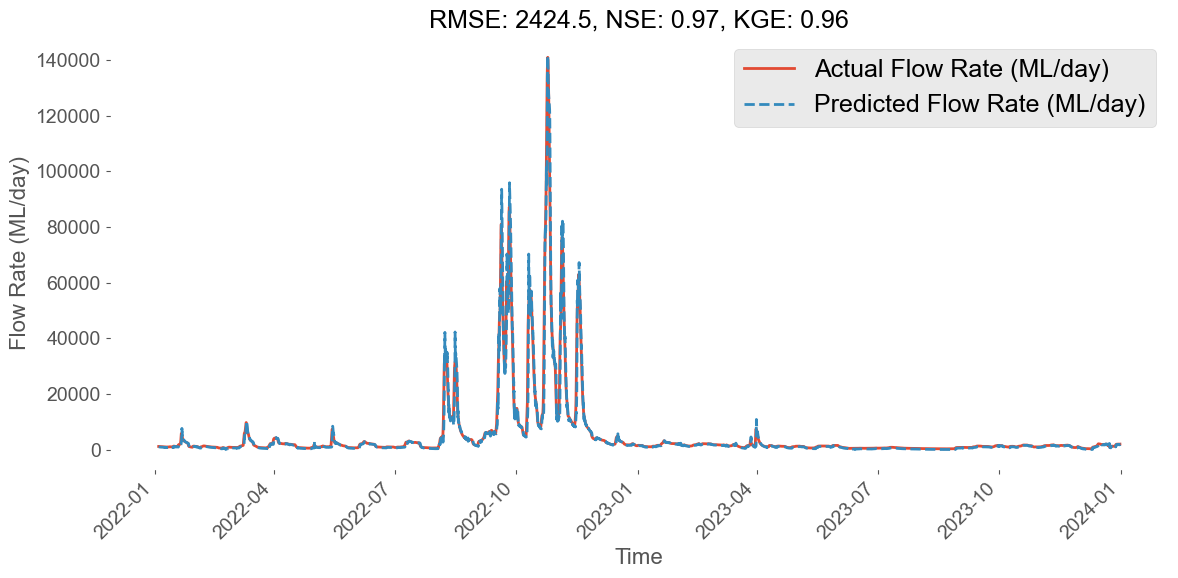

In [3]:
# ---- MAIN: All steps in one cell ----
file_path = './test_419012.csv'
window_size = 48
lead_time = 16

model_path = "lstm_flood_pro10_model1.h5"
weights_path = model_path + "_best_val.weights.h5"
scaler_path = model_path.replace('.h5', '_scaler.pkl')

# 1. Load data
df = load_data(file_path)

# 2. Load the saved scaler
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Cannot find scaler file: {scaler_path}")
scaler = joblib.load(scaler_path)

# 3. Preprocess new data
X_new, Y_new_scaled, Y_new_unscaled, new_dates = preprocess_data_inference(
    df, scaler, column='Varibale Value', window_size=window_size, lead_time=lead_time
)

# 4. Build model architecture (must match trained model)
model = build_lstm_model(window_size=window_size, lead_time=lead_time)

# 5. Load trained weights
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Cannot find weights file: {weights_path}")
model.load_weights(weights_path)

# 6. Make predictions
Y_new_predictions = forecast(model, X_new, scaler)

# 7. Plot and save figure
plot_results(Y_new_unscaled, Y_new_predictions, new_dates, save_path="prediction_vs_actual.png")

# 8. Save predictions and actuals for each lead as Excel
save_results_excel_per_lead(Y_new_unscaled, Y_new_predictions, new_dates, save_path="prediction_results_by_lead.xlsx")

